In [1]:
import warnings

import spacy
import unicodedata
import re
import string
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from collections import Counter
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize 
from nltk.stem import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from textblob import TextBlob
from wordcloud import WordCloud

# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../b. Datasets/Online Store Reviews.csv')

In [3]:
data.shape

(179, 4)

In [4]:
display(data.head(2))
display(data.tail(2))

,Unnamed: 0,Id,Text,Score
0,0,3306,"I HATE SUCRALOSE.<br /><br />Honestly, I don't...",3
1,1,7851,I love rice and this was good with all kinds o...,5


,Unnamed: 0,Id,Text,Score
177,177,567957,I wanted this for the omega 3's but my daughte...,2
178,178,568004,This looks and smells great but my son didn't ...,2


In [5]:
df = data[['Text', 'Score']].copy(deep=True)

In [6]:
display(df.head(2))
display(df.tail(2))

,Text,Score
0,"I HATE SUCRALOSE.<br /><br />Honestly, I don't...",3
1,I love rice and this was good with all kinds o...,5


,Text,Score
177,I wanted this for the omega 3's but my daughte...,2
178,This looks and smells great but my son didn't ...,2


In [8]:
def remove_accented_characters(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

In [10]:
def remove_html_tags(text):
    return re.sub(r'<.*?>', ' ', text)

In [11]:
def make_lower_case(text):
    return text.lower()

In [13]:
def remove_punctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [14]:
def remove_stopwords(text):
    stopwords_list = stopwords.words('english')
    sentence_list = []
    for word in text.split():
        if word not in stopwords_list:
            sentence_list.append(word)
    return ' '.join(sentence_list)

In [16]:
def lemmatise_text(text):
    wordnet_lemmatiser = WordNetLemmatizer()
    wordnet_map = {
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'J': wordnet.ADJ,
        'R': wordnet.ADV
    }
    
    pos_tagged_text = nltk.pos_tag(text.split())
    return ' '.join([wordnet_lemmatiser.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

In [17]:
nlp = spacy.load("en_core_web_sm")

def lemmatise_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

In [18]:
def remove_multiple_spaces(text):
    return re.sub(r' +', ' ', text)

In [19]:
df["CleanedText"] = df['Text'].apply(remove_html_tags)
df["CleanedText"] = df['CleanedText'].apply(remove_accented_characters)
df["CleanedText"] = df['CleanedText'].apply(make_lower_case)
df["CleanedText"] = df['CleanedText'].apply(remove_punctuations)
df["CleanedText"] = df['CleanedText'].apply(remove_stopwords)
df["CleanedText"] = df['CleanedText'].apply(lemmatise_text)

In [20]:
display(df.head(2))
display(df.tail(2))

,Text,Score,CleanedText
0,"I HATE SUCRALOSE.<br /><br />Honestly, I don't...",3,hate sucralose honestly do not know people can...
1,I love rice and this was good with all kinds o...,5,love rice good kind texture allergic many thin...


,Text,Score,CleanedText
177,I wanted this for the omega 3's but my daughte...,2,want omega 3s daughter would not eat really sm...
178,This looks and smells great but my son didn't ...,2,look smell great son do not really like textur...


## 10 most frequent words used while providing the review

In [22]:
regexp_tokeniser = RegexpTokenizer('\w+')

In [23]:
def tokenise_text(text):
    return regexp_tokeniser.tokenize(text)

In [24]:
df['TokenisedText'] = df['CleanedText'].apply(tokenise_text)

In [26]:
list_of_tokens = []
for token_list in df['TokenisedText']:
    for token in token_list:
        list_of_tokens.append(token)

In [27]:
Counter(list_of_tokens).most_common(5)

[('not', 92), ('like', 92), ('taste', 79), ('good', 77), ('product', 65)]

## Visualising most occurent words

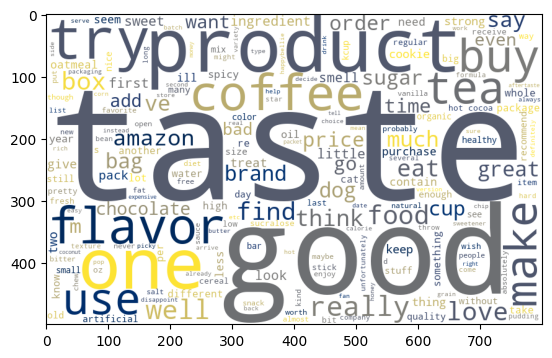

In [29]:
text = ' '.join(list_of_tokens)
wordcloud = WordCloud(width=800, 
                      height=500, 
                      background_color='white', 
                      colormap='cividis_r').generate(text)
plt.imshow(wordcloud)

## Sentiment Analysis

### Assigning the subjectivity response to the content

In [31]:
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

In [32]:
df['Subjectivity'] = df['CleanedText'].apply(get_subjectivity)

In [33]:
df.head(2)

,Text,Score,CleanedText,TokenisedText,Subjectivity
0,"I HATE SUCRALOSE.<br /><br />Honestly, I don't...",3,hate sucralose honestly do not know people can...,"[hate, sucralose, honestly, do, not, know, peo...",0.671711
1,I love rice and this was good with all kinds o...,5,love rice good kind texture allergic many thin...,"[love, rice, good, kind, texture, allergic, ma...",0.628571


### Assigning the polarity response to the content

In [34]:
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

In [35]:
df['Polarity'] = df['CleanedText'].apply(get_polarity)

In [36]:
df.head(2)

,Text,Score,CleanedText,TokenisedText,Subjectivity,Polarity
0,"I HATE SUCRALOSE.<br /><br />Honestly, I don't...",3,hate sucralose honestly do not know people can...,"[hate, sucralose, honestly, do, not, know, peo...",0.671711,-0.057107
1,I love rice and this was good with all kinds o...,5,love rice good kind texture allergic many thin...,"[love, rice, good, kind, texture, allergic, ma...",0.628571,0.700000


### Assigning sentiment to each of the Review
- if polarity < 0 then sentiment ->"Negative"
- if polarity == 0 then sentiment ->"Neutral"
- if polarity > 0 then sentiment ->"Positive"

In [37]:
def get_sentiment(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

In [38]:
df['Sentiment'] = df['Polarity'].apply(get_sentiment)

In [39]:
df.head(2)

,Text,Score,CleanedText,TokenisedText,Subjectivity,Polarity,Sentiment
0,"I HATE SUCRALOSE.<br /><br />Honestly, I don't...",3,hate sucralose honestly do not know people can...,"[hate, sucralose, honestly, do, not, know, peo...",0.671711,-0.057107,Negative
1,I love rice and this was good with all kinds o...,5,love rice good kind texture allergic many thin...,"[love, rice, good, kind, texture, allergic, ma...",0.628571,0.700000,Positive


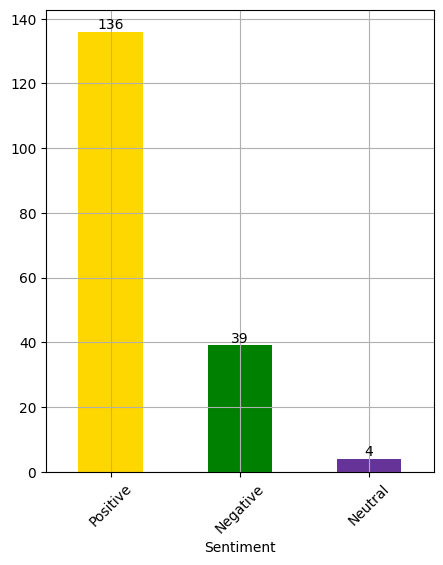

In [40]:
plt.figure(figsize=(5, 6))
countplot = df['Sentiment'].value_counts(sort=True).plot(kind='bar', 
                                                         color=['gold', 'green', 'rebeccapurple'])
plt.bar_label(countplot.containers[0], label_type='edge')
plt.grid()
plt.xticks(rotation=45)
plt.show()